100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]
Epoch 10/10: 100%|██████████| 938/938 [00:22<00:00, 41.96it/s, loss=0.782]


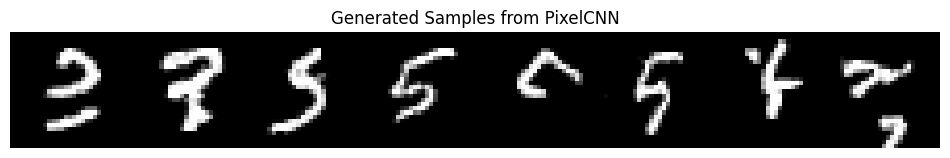

In [1]:
# Autoregressive Model: PixelCNN for MNIST in PyTorch

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
lr = 1e-3
epochs = 10
img_size = 28

# Data loading and preprocessing
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Masked convolution (Type A and B)
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in {'A', 'B'}, "mask_type must be 'A' or 'B'"
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

# PixelCNN model
class PixelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            MaskedConv2d('A', 1, 64, 7, padding=3),
            nn.ReLU(),
            *[layer for _ in range(5) for layer in [MaskedConv2d('B', 64, 64, 7, padding=3), nn.ReLU()]],
            nn.Conv2d(64, 256, 1)
        )

    def forward(self, x):
        return self.net(x)

# Model and optimizer
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for imgs, _ in pbar:
        imgs = (imgs * 255).long().to(device)  # convert to int [0, 255]
        inputs = imgs.float() / 255
        outputs = model(inputs)
        loss = criterion(outputs, imgs.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

# Sampling from model
def sample(model, n_samples=8):
    model.eval()
    samples = torch.zeros(n_samples, 1, img_size, img_size).to(device)
    with torch.no_grad():
        for i in range(img_size):
            for j in range(img_size):
                out = model(samples)
                probs = torch.softmax(out[:, :, i, j], dim=-1)
                samples[:, 0, i, j] = torch.multinomial(probs, 1).squeeze().float() / 255
    return samples

# Show generated images
def show_images(images, title=""):
    grid = torch.cat([img.squeeze(0) for img in images], dim=1).cpu().numpy()
    plt.figure(figsize=(12, 2))
    plt.imshow(grid, cmap="gray")
    plt.axis("off")
    plt.title(title)
    plt.show()

samples = sample(model, 8)
show_images(samples, title="Generated Samples from PixelCNN")
